In [53]:
#!pip install fastai --upgrade
#!pip install fastai2_extensions

In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
from fastai.vision.all import *
import PIL
from fastai2_extensions.interpret.all import *
from sklearn.metrics import accuracy_score
from glob import glob

# Look at the data

In [56]:
STUDY_DIRECTORY =  Path('gdrive/My Drive/MURA_sample') 

In [57]:
df = pd.read_csv(STUDY_DIRECTORY/'data.csv')

In [58]:
df.head()

,img_path,subject_id,study_id,label,is_valid
0,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00008/study1_positive/image1.png,8,00008_study1,positive,False
1,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00008/study1_positive/image2.png,8,00008_study1,positive,False
2,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00008/study1_positive/image3.png,8,00008_study1,positive,False
3,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00050/study1_negative/image1.png,50,00050_study1,negative,False
4,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00050/study1_negative/image2.png,50,00050_study1,negative,False


In [59]:
df_studies = df.drop_duplicates(subset = ["study_id"])

#### Number of unique subjects 


In [60]:
df_studies.subject_id.nunique()

2104

#### Number of unique studies (some patients can have several studies)

In [61]:
df_studies.study_id.nunique()

2185

#### Example of a study data

![study](https://github.com/skaliy/rad230_dl/blob/main/patient00008.png?raw=1)


#### Medical datasets are often imbalanced

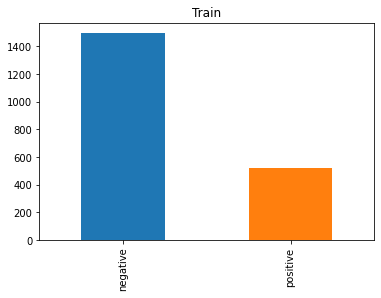

In [62]:
df_studies.loc[~df_studies.is_valid].label.value_counts().plot(kind='bar', color=['C0', 'C1'], title='Train');

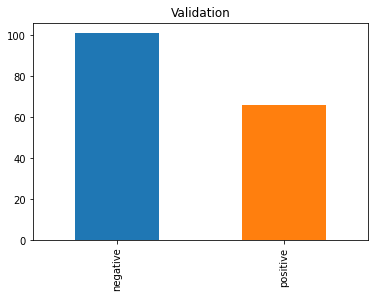

In [63]:
df_studies.loc[df_studies.is_valid].label.value_counts().plot(kind='bar', color=['C0', 'C1'], title='Validation');

In [64]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_x=ColReader('img_path'), 
                   get_y=ColReader('label'),
                   splitter=ColSplitter(col='is_valid'), 
                   item_tfms=Resize(512), 
                   batch_tfms=aug_transforms(size=256))

In [65]:
#### batch size is the number of samples that will be passed through to the network at one time during training

In [66]:
batch_size=16

In [67]:
dls = dblock.dataloaders(df, bs=batch_size)

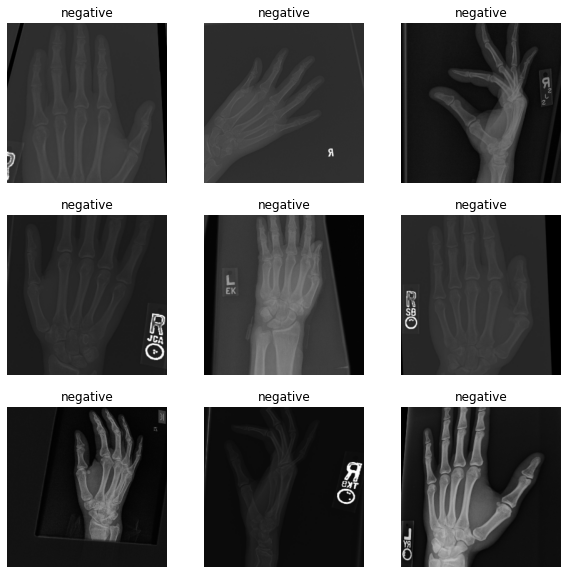

In [68]:
dls.show_batch(figsize=(10, 10))

### Training process

In [69]:
learn = vision_learner(dls, resnet50, metrics=accuracy, model_dir='')

In [70]:
# learn.lr_find()

In [ ]:
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('model-1');

# Intepretation

In [51]:
learn.load(STUDY_DIRECTORY/'model-1');

In [52]:
preds,targs = learn.get_preds(ds_idx=1)
preds = np.argmax(preds, axis=1)

In [ ]:
print('Accuracy:',round(accuracy_score(preds, targs),3))

Accuracy: 0.798


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

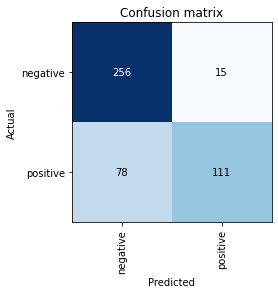

In [ ]:
interp.plot_confusion_matrix()

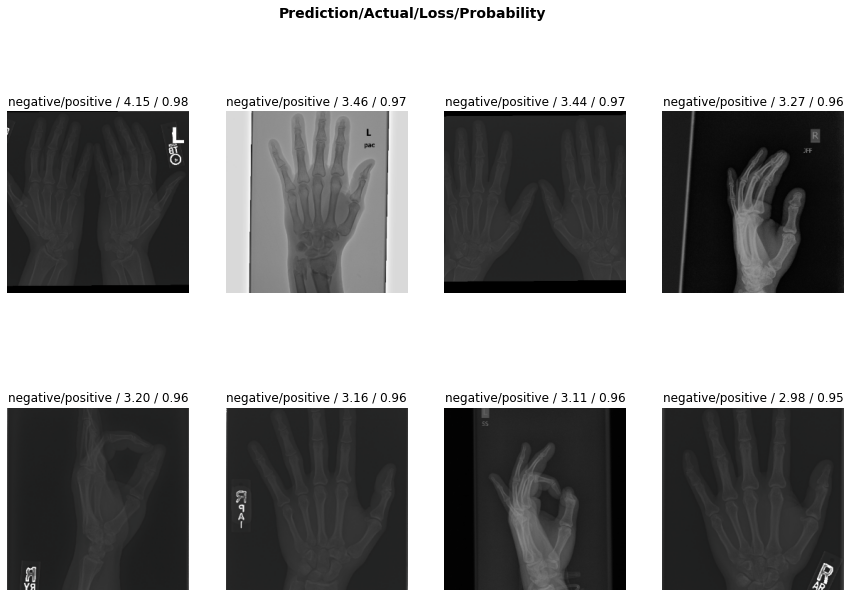

In [ ]:
interp.plot_top_losses(8, figsize=(15,10))

In [ ]:
interp = ClassificationInterpretationEx.from_learner(learn)

In [ ]:
df_positive_validation = df.loc[(df.is_valid) & (df.label=='positive')].reset_index(drop=True)
df_positive_validation.head()

,img_path,subject_id,study_id,label,is_valid
0,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11194/study1_positive/image1.png,11194,11194_study1,positive,True
1,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11194/study1_positive/image2.png,11194,11194_study1,positive,True
2,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11194/study1_positive/image3.png,11194,11194_study1,positive,True
3,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11216/study1_positive/image1.png,11216,11216_study1,positive,True
4,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11216/study1_positive/image2.png,11216,11216_study1,positive,True


In [ ]:
idx = 0
fname = df_positive_validation.img_path.tolist()[idx]
fname

'gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11194/study1_positive/image1.png'

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


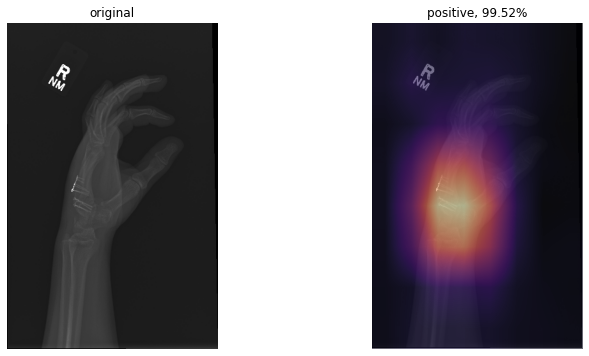

In [ ]:
gcam = GradCam(learn, fname, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

## Study accuracy 

In [ ]:
df_validation = df.loc[df.is_valid].reset_index(drop=True)
df_validation['preds'] = preds
df_validation['targs'] = targs

In [ ]:
df_validation.head()

,img_path,subject_id,study_id,label,is_valid,preds,targs
0,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study1_negative/image1.png,11190,11190_study1,negative,True,0,0
1,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study1_negative/image2.png,11190,11190_study1,negative,True,0,0
2,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study1_negative/image3.png,11190,11190_study1,negative,True,1,0
3,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study2_negative/image1.png,11190,11190_study2,negative,True,0,0
4,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study2_negative/image2.png,11190,11190_study2,negative,True,0,0


In [ ]:
study_preds = []

for study_id in df_validation.study_id.unique(): 
  study_data = df_validation.loc[df_validation.study_id == study_id]
  prediction = max(study_data.preds.tolist())
  df_validation.loc[df_validation.study_id == study_id, 'study_preds'] = prediction

df_validation.study_preds = df_validation.study_preds.astype(int)

In [ ]:
df_validation.head()

,img_path,subject_id,study_id,label,is_valid,preds,targs,study_preds
0,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study1_negative/image1.png,11190,11190_study1,negative,True,0,0,1
1,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study1_negative/image2.png,11190,11190_study1,negative,True,0,0,1
2,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study1_negative/image3.png,11190,11190_study1,negative,True,1,0,1
3,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study2_negative/image1.png,11190,11190_study2,negative,True,0,0,0
4,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11190/study2_negative/image2.png,11190,11190_study2,negative,True,0,0,0


In [ ]:
df_validation_studies = df_validation.drop_duplicates(subset = ["study_id"])

In [ ]:
print('Accuracy:',round(accuracy_score(df_validation_studies.study_preds.tolist(), df_validation_studies.targs.tolist()), 3))

Accuracy: 0.814
